**Functions and data set to optimize in Q1 and Q2**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

In [2]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

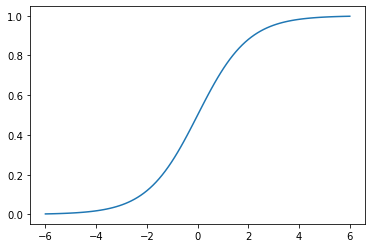

In [3]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

In [4]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, 
                  cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

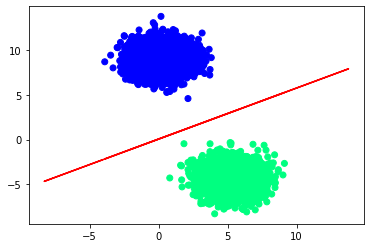

In [5]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. 20 points 

Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [6]:
%matplotlib inline
%load_ext Cython

In [92]:
from numba import jit, vectorize, float64, int64,guvectorize
import seaborn as sns
import math

In [98]:
@vectorize([float64(float64)], target='cpu')
def logistic_numba_cpu(x):
    """Logistic function."""
    return 1/(1 + math.exp(-x))

@vectorize([float64(float64)], target='parallel')
def logistic_numba_parallel(x):
    """Logistic function."""
    return 1/(1 + math.exp(-x))


#@vectorize(target='cpu')
#def gd_numba_cpu(X, y, beta, alpha, niter):
 #   """Gradient descent algorihtm."""
  #  n, p = X.shape
   # Xt = X.T
    #for i in range(niter):
     #   y_pred = logistic_numba_cpu(X @ beta)
      #  epsilon = y - y_pred
       # grad = Xt @ epsilon / n
        #beta += alpha * grad
   # return beta

In [9]:
np.testing.assert_array_almost_equal(logistic(x), logistic_numba_cpu(x))
np.testing.assert_array_almost_equal(logistic(x), logistic_numba_parallel(x))

In [10]:
%timeit logistic(x)

8.8 µs ± 223 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
%timeit logistic_numba_cpu(x)

2.88 µs ± 106 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
%timeit logistic_numba_parallel(x)

331 µs ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [100]:
@jit(float64[:](float64[:]), nopython=True)
def logistic_numba(x):
    return 1/(1 + np.exp(-x))

@jit(float64[:](float64[:,:], float64[:], float64[:], float64, int64), nopython=True)
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta


<ipython-input-100-29a3eed5e29f>:11: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  y_pred = logistic_numba(X @ beta)
<ipython-input-100-29a3eed5e29f>:13: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  grad = Xt @ epsilon / n
/opt/conda/lib/python3.6/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/opt/conda/lib/python3.6/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


In [46]:
b1 = gd(X, y, β, α, niter)
b2 = gd_numba(X, y, β, α, niter)
np.testing.assert_almost_equal(b1, b2)

In [15]:
%timeit gd(X, y, β, α, niter)

1.3 s ± 484 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%timeit gd_numba(X, y, β, α, niter)

550 ms ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


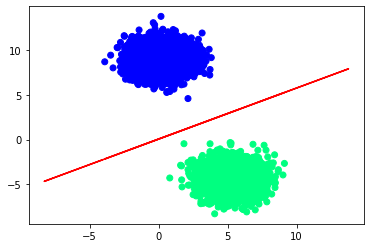

In [48]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd_numba(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass





**2**. 30 points 

Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

In [43]:
%%cython --annotate

import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def logistic_cython(double[:] x):
    cdef int i
    cdef int n = x.shape[0]
    cdef double [:] s = np.zeros(n)
    for i in range(n):
        s[i] = 1.0/(1.0 + exp(-x[i]))
    return s

In [44]:
np.testing.assert_array_almost_equal(logistic_numba_cpu(x), logistic_cython(x))

In [45]:
%timeit logistic_numba_cpu(x)

2.92 µs ± 66.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [46]:
%timeit logistic_cython(x)

5.05 µs ± 116 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [48]:
%%cython --annotate

import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef double[:] logistic_cython(double[:] x):
    cdef int i
    cdef int n = x.shape[0]
    cdef double [:] s = np.zeros(n)
    
    for i in range(n):
        s[i] = 1/(1+exp(-x[i]))
    return s

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def gd_cython(double[:, ::1] X, double[:] y, double[:] beta, double alpha, int niter):   
    cdef int n = X.shape[0]
    cdef int p = X.shape[1]
    cdef double[:] eps = np.zeros(n)
    cdef double[:] y_pred = np.zeros(n)
    cdef double[:] grad = np.zeros(p)  
    cdef int i, j, k
    cdef double[:, :] Xt = X.T
    
    for i in range(niter):
        y_pred = logistic_cython(np.dot(X,beta))
        for j in range(n):
            eps[j] =y[j]-y_pred[j]
        grad=(np.dot(Xt,eps))/n
        for k in range(p):
            beta[k] += alpha * grad[k]
    return beta

In [49]:
np.testing.assert_array_almost_equal(gd_numba(X, y, β, α, niter), gd_cython(X, y, β, α, niter))

In [50]:
%timeit gd_numba(X, y, β, α, niter)

459 ms ± 38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit gd_cython(X, y, β, α, niter)

387 ms ± 43.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**3**. 25 points

Implement Newton's method in 1D for root finding. Pass in the function and gradient as generalized function pointers. Use the method to find all roots of the polynomial equation $f(x) = x^3 - 7x - 6$

In [102]:
%%file newton.cpp
#include <iostream>
#include <vector>
#include <numeric>
#include <iomanip>
#include <cmath>
#include <functional> 
using std::vector;
using std::cout;
using std::function;

using func = function<double(double)>;

double newton(double x0, func f, func grad, int max_iter=10) {
    double x = x0;
    for (int i=0; i<max_iter; i++) {
        x -= f(x)/grad(x);
    }
    return x;
}

int main()
{
    
    auto f = [](double x) { return pow(x,3)-7*x-6; };
    auto grad = [](double x) { return 3.0*pow(x, 2)-7; };
    
    vector<double> x = {-5, 0, 5};
    for (auto& x0: x) {
        cout << std::setw(2) << x0 << ": " << std::setw(3) << newton(x0, f, grad) << "\n";
    }
}


Overwriting newton.cpp


In [103]:
%%bash
g++ -std=c++11 newton.cpp -o newton.exe

In [104]:
%%bash
./newton.exe

-5:  -2
 0:  -1
 5:   3


**4**. 25 points

Use the `armadillo` or `eigen` library to

- Generate 10 x-coordinates linearly spaced between 10 and 15
- Generate 10 random y-values as $y = 3x^2 - 7x + 2 + \epsilon$ where $\epsilon \sim 10 N(0,1)$
- Find the length of $x$ and $y$ and the Euclidean distance between $x$ and $y$
- Find the correlation between $x$ and $y$
- Solve the linear system to find a quadratic fit for this data

In [179]:
%%file fun1.cpp
#include <iostream>
#include <fstream>
#include <armadillo>
using std::cout;
using std::ofstream;

int main() 
{
    using namespace arma;

    vec x1 = linspace<vec>(10.0,15.0,10);
    vec eps1 = 10*randn<vec>(10);
    vec y1 = 3*pow(x1,2) - 7*x1 + 2 + eps1; 

    cout << "x:\n" << x1 << "\n";
    cout << "y:\n" << y1 << "\n";

    cout << "leht of x: " << norm(x1) << "\n";
    cout << "lnght of y: " << norm(y1) << "\n";

    cout << "Euclidean distance between x and y: " << norm(x1 -y1) << "\n";

    cout << "Correlation of x and y: " << cor(x1, y1) << "\n";

    mat A = join_rows(ones<vec>(10), x1);
    A = join_rows(A, pow(x1,2));
    cout << "A:\n" << A << "\n";

    vec b = solve(A, y1);
    cout << "b:\n" << b << "\n";

    ofstream fout1("x1.txt");
    x1.print(fout1);
    ofstream fout2("y1.txt");
    y1.print(fout2);
    ofstream fout3("b.txt");
    b.print(fout3);
}

Overwriting fun1.cpp


In [180]:
%%bash
g++ -std=c++11 fun1.cpp -o fun1.exe -larmadillo

In [181]:
%%bash
./fun1.exe

x:
   10.0000
   10.5556
   11.1111
   11.6667
   12.2222
   12.7778
   13.3333
   13.8889
   14.4444
   15.0000

y:
   2.2513e+02
   2.7027e+02
   2.9660e+02
   3.2962e+02
   3.6404e+02
   3.9959e+02
   4.2064e+02
   4.8632e+02
   5.3136e+02
   5.5517e+02

leht of x: 39.8493
lnght of y: 1271.44
Euclidean distance between x and y: 1232
Correlation of x and y:    0.9956

A:
   1.0000e+00   1.0000e+01   1.0000e+02
   1.0000e+00   1.0556e+01   1.1142e+02
   1.0000e+00   1.1111e+01   1.2346e+02
   1.0000e+00   1.1667e+01   1.3611e+02
   1.0000e+00   1.2222e+01   1.4938e+02
   1.0000e+00   1.2778e+01   1.6327e+02
   1.0000e+00   1.3333e+01   1.7778e+02
   1.0000e+00   1.3889e+01   1.9290e+02
   1.0000e+00   1.4444e+01   2.0864e+02
   1.0000e+00   1.5000e+01   2.2500e+02

b:
  -66.5216
    5.6618
    2.4158



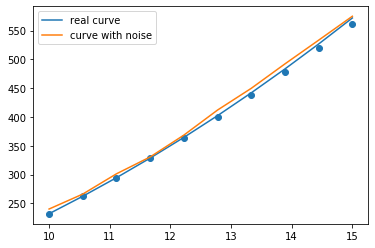

In [163]:
x1=np.linspace(10,15,10)
y1=3*x*x-7*x+2
y2=y1+np.random.rand(10)*10
beta=np.array([-66.5216,5.6618,2.4158])
ycc=A@beta.T


import matplotlib.pyplot as plt
plt.scatter(x,ycc)
plt.plot(x,y1,label='real curve')
plt.plot(x,y2,label='curve with noise')
plt.legend()
pass